## Analysis code - average results

In [28]:
# load libraries
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
import pdb

# For plotting
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode() # for exporting


# for statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


# #uncertainties packages
# from uncertainties import ufloat
# from uncertainties.umath import *  #e.g. sqrt()
# from uncertainties import unumpy

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML
# uncomment this line and run the cell --> fit the cells to screen. Comment and re-run to disable full width.
# display(HTML("<style>.container { width:100% !important; }</style>"))

### Input

In [29]:
## probably not usable class_id: 26, 56
## input
data_path = "../data"
input_path = f"{data_path}/experiment-result-2021-06-15.csv"
input_path_uncomp = f"{data_path}/experiment-uncomp-06-14-2021.csv"
gt_tracking_path = f"{data_path}/experiment_gt_tracking-2021-06-05.csv"
visual_metric = "mAP50"
averaged_result_class = "all"

In [30]:
df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
df = df[header] # re-arrange
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == f"{averaged_result_class}"]
# display(df_all)
seq_list = list(df['seq_name'].unique())
num_seq = len(seq_list)
temp_data = df_all[df_all['seq_name'] == "BasketballDrive"]


#initialize df_summary
#header_std = [f"{col}_std" for col in header ]#if col !='qp' and col != 'msr']
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']

df_summary = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)

# averaging
for seq_name in seq_list:
    # exclude training sequence and exclude Cactus as well if tracking person only 
    if seq_name == "PartyScene": 
        continue
    df_seq_all = df_all[df_all['seq_name'] == seq_name]
    df_seq_all.pop('class_cat')
    df_seq_all.pop('seq_name')
    df_seq_all.pop('class_id')

#     df_seq_all = df_seq_all.replace(np.nan, 0)
#     print(seq_name)
#     display(df_seq_all)

    for col in df_seq_all:
        if col == 'QP' or col == 'MSR':
            df_summary[col] = df_seq_all[col].values
        else:
            df_summary[col] += df_seq_all[col].values


for col in df_summary:
    if col !='QP' and col != 'MSR':
        df_summary[col] = df_summary[col] / num_seq

# df_summary['TP_from_Prcn'] = (df_summary['Prcn'] / 100) * df_summary['FP'] / ( 1 - (df_summary['Prcn'] / 100) )
# df_summary['TP_from_Rcll'] = (df_summary['Rcll'] / 100) * df_summary['FN'] / ( 1 - (df_summary['Rcll'] / 100) ) # result is different
# df_summary['TP_est'] = (df_summary['TP_from_Prcn'] + df_summary['TP_from_Rcll']) / 2
# display(df_summary)
df_seq_cl = df_summary
df_seq_cl_uncomp = df_seq_cl[df_seq_cl['MSR'] == 0].reset_index(drop=True) # reset index so that you can access the first element
df_seq_cl_msr8 = df_seq_cl[df_seq_cl['MSR'] == 8]
df_seq_cl_msr16 = df_seq_cl[df_seq_cl['MSR'] == 16]
df_seq_cl_msr32 = df_seq_cl[df_seq_cl['MSR'] == 32]
df_seq_cl_msr64 = df_seq_cl[df_seq_cl['MSR'] == 64]

with pd.option_context('precision', 2):
    df_seq_cl_uncomp['QP'] = 'Uncompressed'
    df_seq_cl_uncomp['MSR'] = 'Uncompressed'
    display(df_seq_cl_uncomp)
    display(df_seq_cl_msr8)
    display(df_seq_cl_msr16)
    display(df_seq_cl_msr32)
    display(df_seq_cl_msr64)
print(df_seq_cl_uncomp.to_latex(index=False, multirow=True))
print(df_seq_cl_msr8.to_latex(index=False, multirow=True))
print(df_seq_cl_msr16.to_latex(index=False, multirow=True))
print(df_seq_cl_msr32.to_latex(index=False, multirow=True))
print(df_seq_cl_msr64.to_latex(index=False, multirow=True))



fig = go.Figure()
x_base = df_seq_cl_msr32['QP']
y_const = [df_seq_cl_uncomp[visual_metric][0] for i in range(len(x_base))]
fig.add_trace(go.Scatter(x=x_base, y=y_const,
                    mode='lines',
                    line=dict(dash='dash'),
                    name='Uncompressed'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr8[visual_metric],
                    mode='lines+markers',
                    name='MSR=8'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr16[visual_metric],
                    mode='lines+markers',
                    name='MSR=16'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr32[visual_metric],
                    mode='lines+markers',
                    name='MSR=32'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr64[visual_metric],
                    mode='lines+markers',
                    name='MSR=64'))
x_name = "QP"
y_name = visual_metric
z_name = "MSR"
fig.update_layout( font=dict(
                color="black",
                size=14),
                   xaxis_title=x_name,
                   yaxis_title=y_name)
fig.show()
# fig.write_image("C:/OneDrive/SFU/ENSC498, 499/images/averaged_result_all.pdf",width=1000, height=576)



fig = go.Figure()
df_seq_cl_qp18 = df_seq_cl[df_seq_cl['QP'] == 18]
df_seq_cl_qp22 = df_seq_cl[df_seq_cl['QP'] == 22]
df_seq_cl_qp26 = df_seq_cl[df_seq_cl['QP'] == 26]
df_seq_cl_qp30 = df_seq_cl[df_seq_cl['QP'] == 30]
df_seq_cl_qp34 = df_seq_cl[df_seq_cl['QP'] == 34]
df_seq_cl_qp38 = df_seq_cl[df_seq_cl['QP'] == 38]
df_seq_cl_qp42 = df_seq_cl[df_seq_cl['QP'] == 42]
df_seq_cl_qp46 = df_seq_cl[df_seq_cl['QP'] == 46]


with pd.option_context('precision', 2):
    df_seq_cl_uncomp['QP'] = 'Uncompressed'
    df_seq_cl_uncomp['MSR'] = 'Uncompressed'
    display(df_seq_cl_uncomp)
    display(df_seq_cl_qp18)
    display(df_seq_cl_qp22)
    display(df_seq_cl_qp26)
    display(df_seq_cl_qp30)
    display(df_seq_cl_qp34)
    display(df_seq_cl_qp38)
    display(df_seq_cl_qp42)
    display(df_seq_cl_qp46)


x_base = df_seq_cl_qp18['MSR']
y_const = [df_seq_cl_uncomp[visual_metric][0] for i in range(len(x_base))]
fig.add_trace(go.Scatter(x=x_base, y=y_const,
                    mode='lines',
                    line=dict(dash='dash'),
                    name='Uncompressed'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp18[visual_metric],
                    mode='lines+markers',
                    name='QP=18'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp22[visual_metric],
                    mode='lines+markers',
                    name='QP=22'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp26[visual_metric],
                    mode='lines+markers',
                    name='QP=26'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp30[visual_metric],
                    mode='lines+markers',
                    name='QP=30'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp34[visual_metric],
                    mode='lines+markers',
                    name='QP=34'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp38[visual_metric],
                    mode='lines+markers',
                    name='QP=38'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp42[visual_metric],
                    mode='lines+markers',
                    name='QP=42'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_qp42[visual_metric],
                    mode='lines+markers',
                    name='QP=46'))
x_name = "MSR"
y_name = visual_metric
z_name = "QP"
fig.update_layout( font=dict(
                color="black",
                size=14),
                   xaxis_title=x_name,
                   yaxis_title=y_name)


fig.show()
# fig.write_image("C:/OneDrive/SFU/ENSC498, 499/images/averaged_result_all_msr.pdf",width=1000, height=576)


QP           MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
0  Uncompressed  Uncompressed 1762.58 932.83 2522.67 49.88 61.13 43.48   62.17      89.25 72.08 12.25 4.67 3.25 4.33 2249.75 441.67 2035.50 24.08 35.17  64.26 54.49 82.03

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
1   18    8 1770.08 947.50 2515.17 50.60 61.55 44.26   62.18      88.58 71.92 12.25 4.50 3.17 4.58 2246.75 466.83 2038.50 24.17 36.00  64.42 53.97 82.11
5   22    8 1780.83 931.92 2504.42 50.46 61.66 43.96   61.62      88.85 71.65 12.25 4.58 3.17 4.50 2250.00 458.75 2035.25 24.92 35.58  64.01 53.70 82.10
9   26    8 1751.67 874.17 2533.58 50.41 62.63 43.28   60.49      89.73 71.22 12.25 4.33 3.17 4.75 2192.92 428.92 2092.33 24.33 35.50  62.16 53.24 82.28
13  30    8 1731.50 960.08 2553.75 49.88 62.12 42.65   60.21      89.83 71.07 12.25 4.33 3.08 4.83 2234.42 453.17 2050.83 23.67 35.00  62.66 53.13 82.16
17  34    8 1653.92 855.08 2631.33 48.14 62.23 39.93   57.12      90.61 69.26 12.25 4.08 3.00 5.17 2092.58 412.42 2192.67 21.75 32.25  59.58 50.64 82.42
21  38    8 1488.50 781.08 2796.75 44.56 61.38 35.62   52.70      91.52 65.97 12.25 3.42 3.17 5.67 1912.42 353.17 2372.83 21.92 30.67  55.50 47.15 82.29
25  42    8 1399.25 733.83 2886.00 40.92 60.67 32.08   46.86      91.35 60.24 12.25 3.08 3.25 5.92 1805.67 323.42 2479.58 20.83 33.50  49.66 41.48 81.42
29  46    8 1046.50 673.33 3238.75 30.48 57.12 22.40   33.09      87.46 45.48 12.25 1.75 3.08 7.42 1358.33 357.50 2926.92 18.00 28.25  37.34 27.64 80.47

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
2   18   16 1749.25 964.25 2536.00 50.48 61.51 44.07   62.04      88.73 71.88 12.25 4.50 3.33 4.42 2248.00 461.50 2037.25 25.08 35.25  64.37 54.03 82.08
6   22   16 1790.08 932.17 2495.17 50.40 61.45 43.96   61.39      88.42 71.38 12.25 4.58 3.17 4.50 2242.17 476.08 2043.08 24.33 35.75  64.09 53.36 82.16
10  26   16 1728.75 886.25 2556.50 50.48 62.82 43.28   60.43      89.89 71.21 12.25 4.33 3.42 4.50 2190.50 420.50 2094.75 23.58 34.08  63.03 53.36 82.40
14  30   16 1728.33 954.08 2556.92 48.91 61.02 41.83   60.04      90.00 71.10 12.25 4.17 3.42 4.67 2225.42 453.00 2059.83 23.17 34.25  62.62 53.21 82.26
18  34   16 1604.67 906.00 2680.58 46.94 60.73 38.90   56.89      90.40 69.10 12.25 3.83 3.17 5.25 2087.08 419.58 2198.17 21.67 32.08  59.32 50.49 82.29
22  38   16 1496.58 791.58 2788.67 45.47 62.23 36.46   53.13      91.95 66.47 12.25 3.58 3.08 5.58 1934.58 349.58 2350.67 23.17 31.83  56.66 47.81 82.04
26  42   16 1379.33 786.17 2905.92 39.76 58.32 31.38   47.28      90.98 60.56 12.25 2.92 3.25 6.08 1809.33 352.17 2475.92 20.33 33.58  49.24 41.72 81.33
30  46   16 1078.17 613.00 3207.08 32.42 61.75 23.68   33.48      88.70 45.99 12.25 1.92 2.83 7.50 1368.58 318.58 2916.67 18.42 28.58  37.21 27.67 79.77

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
3   18   32 1768.58 939.58 2516.67 50.67 61.70 44.31   61.98      88.62 71.78 12.25 4.58 3.25 4.42 2245.33 458.83 2039.92 25.00 35.58  64.54 53.80 82.08
7   22   32 1791.42 920.08 2493.83 50.38 61.48 43.92   61.49      88.46 71.42 12.25 4.58 3.25 4.42 2254.00 453.50 2031.25 25.00 36.42  64.47 53.15 82.18
11  26   32 1724.42 939.08 2560.83 49.68 61.44 42.82   60.80      89.44 71.32 12.25 4.42 3.08 4.75 2204.33 455.17 2080.92 24.25 35.75  63.11 53.41 82.34
15  30   32 1697.08 950.92 2588.17 49.14 61.34 41.91   59.79      89.85 70.91 12.25 4.17 3.42 4.67 2196.08 447.92 2089.17 24.08 36.58  62.84 52.83 82.25
19  34   32 1628.42 865.50 2656.83 48.13 61.98 39.98   57.10      90.70 69.32 12.25 4.00 3.00 5.25 2096.75 393.17 2188.50 21.42 31.58  59.66 50.83 82.38
23  38   32 1512.50 778.75 2772.75 45.10 61.90 36.13   53.20      91.29 66.31 12.25 3.58 3.08 5.58 1934.67 352.58 2350.58 20.75 31.08  55.69 47.57 81.98
27  42   32 1367.25 779.58 2918.00 39.92 58.70 31.38   47.28      90.61 60.48 12.25 3.00 3.42 5.83 1808.25 334.58 2477.00 19.67 32.25  49.68 41.48 81.16
31  46   32 1018.67 693.75 3266.58 30.47 57.32 22.52   33.53      88.54 45.93 12.25 1.75 3.08 7.42 1363.75 344.67 2921.50 19.25 28.25  37.40 27.97 81.11

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
4   18   64 1756.00 964.33 2529.25 50.10 61.04 43.73   62.17      88.82 72.02 12.25 4.67 3.00 4.58 2252.83 463.50 2032.42 24.75 36.75  64.59 54.24 82.06
8   22   64 1768.75 944.75 2516.50 50.68 61.77 44.22   61.56      88.53 71.48 12.25 4.42 3.33 4.50 2244.83 464.67 2040.42 24.75 36.75  63.76 53.33 82.12
12  26   64 1722.25 906.50 2563.00 49.46 61.60 42.30   60.18      89.24 70.90 12.25 4.33 3.25 4.67 2184.42 440.33 2100.83 24.33 34.50  62.87 52.62 82.37
16  30   64 1731.25 949.00 2554.00 49.44 61.59 42.27   59.80      89.16 70.64 12.25 4.33 3.08 4.83 2214.75 461.50 2070.50 23.83 34.50  61.37 52.47 82.28
20  34   64 1615.58 880.42 2669.67 46.90 60.65 38.91   57.32      91.40 69.69 12.25 3.83 3.25 5.17 2102.25 389.75 2183.00 20.92 32.17  59.90 51.51 82.42
24  38   64 1508.92 765.42 2776.33 46.25 63.23 37.09   52.56      90.69 65.69 12.25 3.50 3.08 5.67 1917.75 352.58 2367.50 20.33 31.83  55.29 46.48 81.96
28  42   64 1404.50 744.42 2880.75 42.43 62.55 33.18   47.31      90.25 60.65 12.25 3.00 3.33 5.92 1805.17 339.75 2480.08 18.83 32.75  49.85 41.57 81.38
32  46   64  995.00 729.42 3290.25 29.98 56.74 22.02   33.18      87.92 45.43 12.25 1.75 3.08 7.42 1364.33 356.08 2920.92 19.25 29.17  37.50 27.29 80.75

\begin{tabular}{llrrrrrrrrrrrrrrrrrrrrr}
\toprule
          QP &          MSR &    IDTP &   IDFP &    IDFN &  IDF1 &   IDP &   IDR &  Recall &  Precision &    F1 &    GT &   MT &   PT &   ML &      TP &     FP &      FN &   IDs &    FM &  mAP50 &  MOTA &  MOTP \\
\midrule
Uncompressed & Uncompressed & 1762.58 & 932.83 & 2522.67 & 49.88 & 61.13 & 43.48 &   62.17 &      89.25 & 72.08 & 12.25 & 4.67 & 3.25 & 4.33 & 2249.75 & 441.67 & 2035.50 & 24.08 & 35.17 &  64.26 & 54.49 & 82.03 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 QP &  MSR &    IDTP &   IDFP &    IDFN &  IDF1 &   IDP &   IDR &  Recall &  Precision &    F1 &    GT &   MT &   PT &   ML &      TP &     FP &      FN &   IDs &    FM &  mAP50 &  MOTA &  MOTP \\
\midrule
 18 &    8 & 1770.08 & 947.50 & 2515.17 & 50.60 & 61.55 & 44.26 &   62.18 &      88.58 & 71.92 & 12.25 & 4.50 & 3.17 & 4.58 & 2246.75 & 466.83 & 2038.50 & 24.17 & 36.00 &  64.42 & 53.97 & 82.11 \\
 22 &    8 & 1780.83 & 931.92 & 2

QP           MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
0  Uncompressed  Uncompressed 1762.58 932.83 2522.67 49.88 61.13 43.48   62.17      89.25 72.08 12.25 4.67 3.25 4.33 2249.75 441.67 2035.50 24.08 35.17  64.26 54.49 82.03

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
1  18    8 1770.08 947.50 2515.17 50.60 61.55 44.26   62.18      88.58 71.92 12.25 4.50 3.17 4.58 2246.75 466.83 2038.50 24.17 36.00  64.42 53.97 82.11
2  18   16 1749.25 964.25 2536.00 50.48 61.51 44.07   62.04      88.73 71.88 12.25 4.50 3.33 4.42 2248.00 461.50 2037.25 25.08 35.25  64.37 54.03 82.08
3  18   32 1768.58 939.58 2516.67 50.67 61.70 44.31   61.98      88.62 71.78 12.25 4.58 3.25 4.42 2245.33 458.83 2039.92 25.00 35.58  64.54 53.80 82.08
4  18   64 1756.00 964.33 2529.25 50.10 61.04 43.73   62.17      88.82 72.02 12.25 4.67 3.00 4.58 2252.83 463.50 2032.42 24.75 36.75  64.59 54.24 82.06

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
5  22    8 1780.83 931.92 2504.42 50.46 61.66 43.96   61.62      88.85 71.65 12.25 4.58 3.17 4.50 2250.00 458.75 2035.25 24.92 35.58  64.01 53.70 82.10
6  22   16 1790.08 932.17 2495.17 50.40 61.45 43.96   61.39      88.42 71.38 12.25 4.58 3.17 4.50 2242.17 476.08 2043.08 24.33 35.75  64.09 53.36 82.16
7  22   32 1791.42 920.08 2493.83 50.38 61.48 43.92   61.49      88.46 71.42 12.25 4.58 3.25 4.42 2254.00 453.50 2031.25 25.00 36.42  64.47 53.15 82.18
8  22   64 1768.75 944.75 2516.50 50.68 61.77 44.22   61.56      88.53 71.48 12.25 4.42 3.33 4.50 2244.83 464.67 2040.42 24.75 36.75  63.76 53.33 82.12

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
9   26    8 1751.67 874.17 2533.58 50.41 62.63 43.28   60.49      89.73 71.22 12.25 4.33 3.17 4.75 2192.92 428.92 2092.33 24.33 35.50  62.16 53.24 82.28
10  26   16 1728.75 886.25 2556.50 50.48 62.82 43.28   60.43      89.89 71.21 12.25 4.33 3.42 4.50 2190.50 420.50 2094.75 23.58 34.08  63.03 53.36 82.40
11  26   32 1724.42 939.08 2560.83 49.68 61.44 42.82   60.80      89.44 71.32 12.25 4.42 3.08 4.75 2204.33 455.17 2080.92 24.25 35.75  63.11 53.41 82.34
12  26   64 1722.25 906.50 2563.00 49.46 61.60 42.30   60.18      89.24 70.90 12.25 4.33 3.25 4.67 2184.42 440.33 2100.83 24.33 34.50  62.87 52.62 82.37

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
13  30    8 1731.50 960.08 2553.75 49.88 62.12 42.65   60.21      89.83 71.07 12.25 4.33 3.08 4.83 2234.42 453.17 2050.83 23.67 35.00  62.66 53.13 82.16
14  30   16 1728.33 954.08 2556.92 48.91 61.02 41.83   60.04      90.00 71.10 12.25 4.17 3.42 4.67 2225.42 453.00 2059.83 23.17 34.25  62.62 53.21 82.26
15  30   32 1697.08 950.92 2588.17 49.14 61.34 41.91   59.79      89.85 70.91 12.25 4.17 3.42 4.67 2196.08 447.92 2089.17 24.08 36.58  62.84 52.83 82.25
16  30   64 1731.25 949.00 2554.00 49.44 61.59 42.27   59.80      89.16 70.64 12.25 4.33 3.08 4.83 2214.75 461.50 2070.50 23.83 34.50  61.37 52.47 82.28

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
17  34    8 1653.92 855.08 2631.33 48.14 62.23 39.93   57.12      90.61 69.26 12.25 4.08 3.00 5.17 2092.58 412.42 2192.67 21.75 32.25  59.58 50.64 82.42
18  34   16 1604.67 906.00 2680.58 46.94 60.73 38.90   56.89      90.40 69.10 12.25 3.83 3.17 5.25 2087.08 419.58 2198.17 21.67 32.08  59.32 50.49 82.29
19  34   32 1628.42 865.50 2656.83 48.13 61.98 39.98   57.10      90.70 69.32 12.25 4.00 3.00 5.25 2096.75 393.17 2188.50 21.42 31.58  59.66 50.83 82.38
20  34   64 1615.58 880.42 2669.67 46.90 60.65 38.91   57.32      91.40 69.69 12.25 3.83 3.25 5.17 2102.25 389.75 2183.00 20.92 32.17  59.90 51.51 82.42

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
21  38    8 1488.50 781.08 2796.75 44.56 61.38 35.62   52.70      91.52 65.97 12.25 3.42 3.17 5.67 1912.42 353.17 2372.83 21.92 30.67  55.50 47.15 82.29
22  38   16 1496.58 791.58 2788.67 45.47 62.23 36.46   53.13      91.95 66.47 12.25 3.58 3.08 5.58 1934.58 349.58 2350.67 23.17 31.83  56.66 47.81 82.04
23  38   32 1512.50 778.75 2772.75 45.10 61.90 36.13   53.20      91.29 66.31 12.25 3.58 3.08 5.58 1934.67 352.58 2350.58 20.75 31.08  55.69 47.57 81.98
24  38   64 1508.92 765.42 2776.33 46.25 63.23 37.09   52.56      90.69 65.69 12.25 3.50 3.08 5.67 1917.75 352.58 2367.50 20.33 31.83  55.29 46.48 81.96

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
25  42    8 1399.25 733.83 2886.00 40.92 60.67 32.08   46.86      91.35 60.24 12.25 3.08 3.25 5.92 1805.67 323.42 2479.58 20.83 33.50  49.66 41.48 81.42
26  42   16 1379.33 786.17 2905.92 39.76 58.32 31.38   47.28      90.98 60.56 12.25 2.92 3.25 6.08 1809.33 352.17 2475.92 20.33 33.58  49.24 41.72 81.33
27  42   32 1367.25 779.58 2918.00 39.92 58.70 31.38   47.28      90.61 60.48 12.25 3.00 3.42 5.83 1808.25 334.58 2477.00 19.67 32.25  49.68 41.48 81.16
28  42   64 1404.50 744.42 2880.75 42.43 62.55 33.18   47.31      90.25 60.65 12.25 3.00 3.33 5.92 1805.17 339.75 2480.08 18.83 32.75  49.85 41.57 81.38

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
29  46    8 1046.50 673.33 3238.75 30.48 57.12 22.40   33.09      87.46 45.48 12.25 1.75 3.08 7.42 1358.33 357.50 2926.92 18.00 28.25  37.34 27.64 80.47
30  46   16 1078.17 613.00 3207.08 32.42 61.75 23.68   33.48      88.70 45.99 12.25 1.92 2.83 7.50 1368.58 318.58 2916.67 18.42 28.58  37.21 27.67 79.77
31  46   32 1018.67 693.75 3266.58 30.47 57.32 22.52   33.53      88.54 45.93 12.25 1.75 3.08 7.42 1363.75 344.67 2921.50 19.25 28.25  37.40 27.97 81.11
32  46   64  995.00 729.42 3290.25 29.98 56.74 22.02   33.18      87.92 45.43 12.25 1.75 3.08 7.42 1364.33 356.08 2920.92 19.25 29.17  37.50 27.29 80.75

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



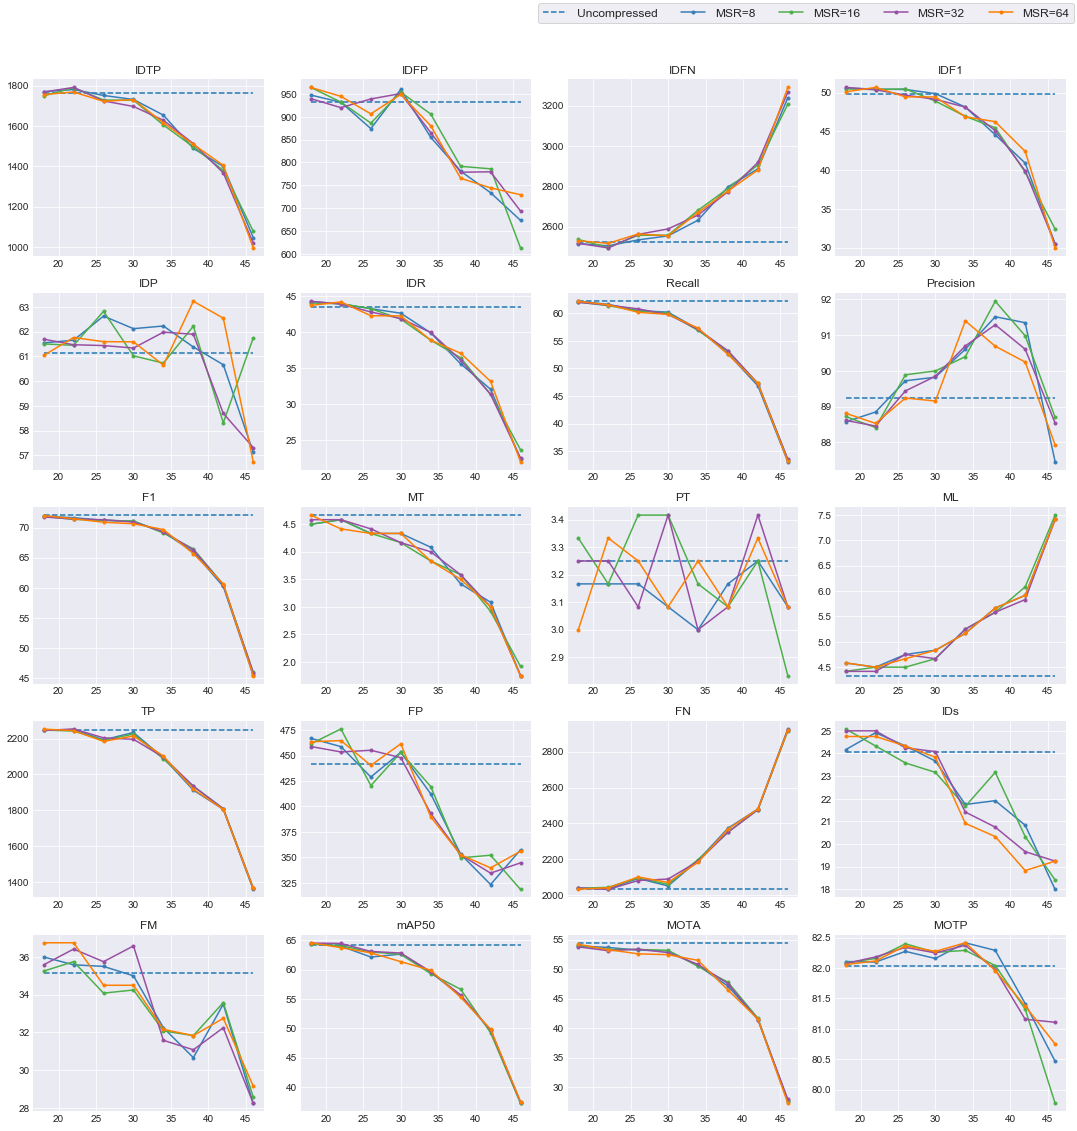

In [31]:
plt.style.use('seaborn-darkgrid')

df_seq = pd.concat([df_seq_cl_msr8, df_seq_cl_msr16, df_seq_cl_msr32, df_seq_cl_msr64])

fig, axs = plt.subplots(5, 4, figsize=(15,15))
palette = plt.get_cmap('Set1')

num = 0
for row in range(5):
    for col in range(4):
        if num == 9: # skiping GT, since it is constant, no need to plot it
            num += 1
        # plot uncompressed result
        x = df_seq.query('MSR == 8')['QP']
        metric = df_seq.iloc[:, 2+num].name
        y_const = [df_seq_cl_uncomp[metric] for i in range(len(x))]
        axs[row, col].set_title(metric)
        axs[row, col].plot(x, y_const, '--', label='Uncompressed')
        
        # plot metric
        y = df_seq.query('MSR == 8').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=8', color=palette(1))
        
        # plot metric
        y = df_seq.query('MSR == 16').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=16', color=palette(2))
        
        # plot metric
        y = df_seq.query('MSR == 32').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=32', color=palette(3))
        
        # plot metric
        y = df_seq.query('MSR == 64').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=64', color=palette(4))
        
    
        num += 1
        
        if row == 0 and col == 0:
            lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
            lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
            fig.legend(lines, labels, loc=4, ncol=5, mode="", borderaxespad=.5,
                       frameon=True, bbox_to_anchor=(0., 1.02, 1., .102), fontsize='large')
            # bbox_to_anchor=(0.125, 0.82, 1., .102)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# axs[0].legend(lines, labels, loc=4, ncol=4,     mode="", borderaxespad=.5, frameon=True,
#         bbox_to_anchor=(0., 1.02, 1., .102))
        
fig.tight_layout()
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/averaged_all_multiplots_qp.pdf", bbox_inches="tight")
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/averaged_0_multiplots_qp.pdf", bbox_inches="tight")

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



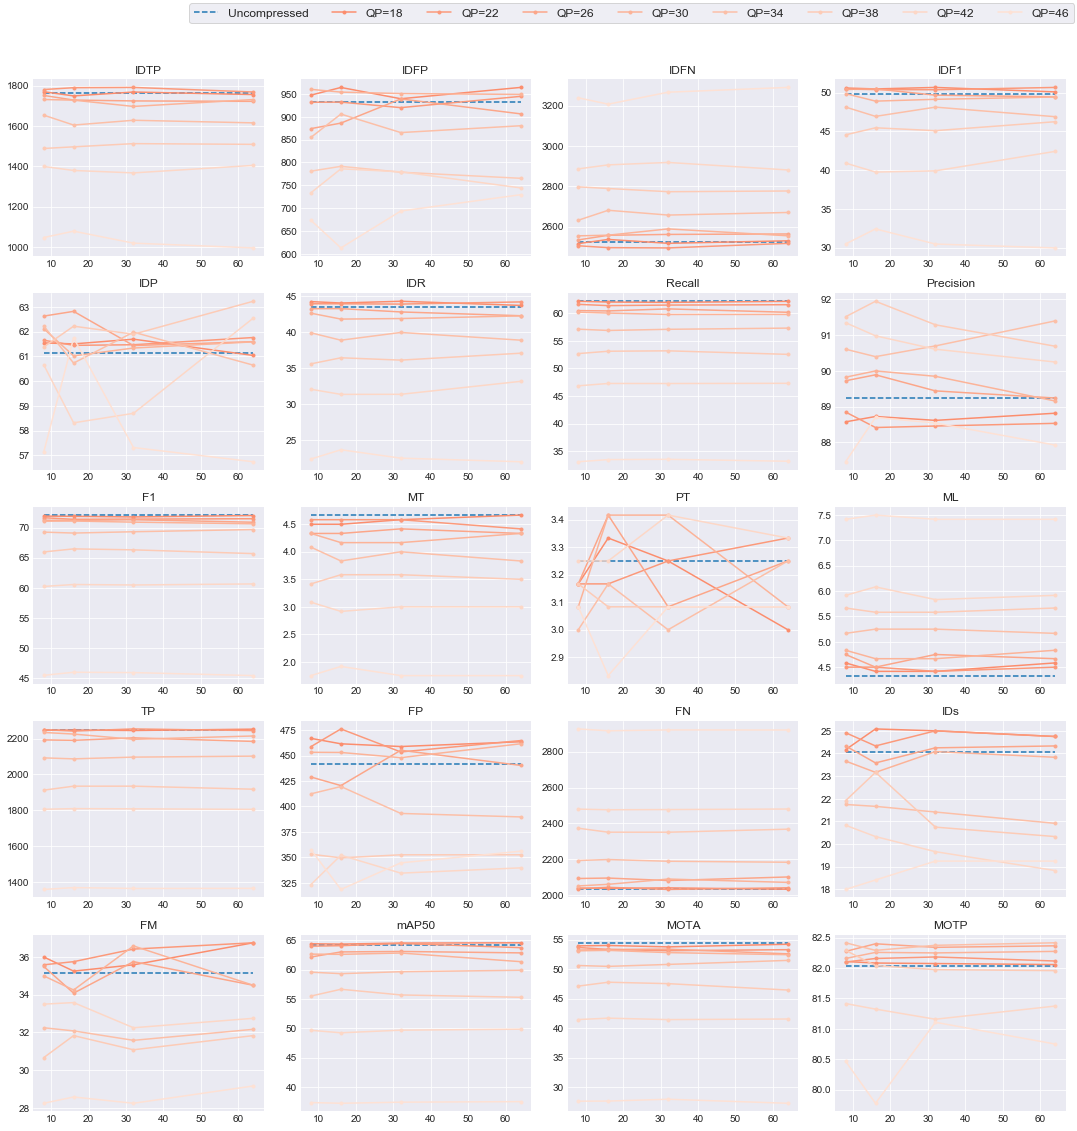

In [5]:
plt.style.use('seaborn-darkgrid')

df_seq = pd.concat([df_seq_cl_qp18, df_seq_cl_qp22, df_seq_cl_qp26,
                    df_seq_cl_qp30,df_seq_cl_qp34,df_seq_cl_qp38,
                    df_seq_cl_qp42, df_seq_cl_qp46])

fig, axs = plt.subplots(5, 4, figsize=(15,15))
# create a color palette
palette = plt.get_cmap('Reds')

num = 0
for row in range(5):
    for col in range(4):
        if num == 9: # skiping GT, since it is constant, no need to plot it
            num += 1
        
        # plot uncompressed result
        x = df_seq.query('QP == 18')['MSR']
        metric = df_seq.iloc[:, 2+num].name
        y_const = [df_seq_cl_uncomp[metric] for i in range(len(x))]
        axs[row, col].set_title(metric)
        axs[row, col].plot(x, y_const, '--', label='Uncompressed')
        
        # plot metric
        y = df_seq.query('QP == 18').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=18', color=palette(100))
        
        # plot metric
        y = df_seq.query('QP == 22').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=22', color=palette(90),)
        
        # plot metric
        y = df_seq.query('QP == 26').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=26', color=palette(80),)
        
        # plot metric
        y = df_seq.query('QP == 30').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=30', color=palette(70),)
        
        # plot metric
        y = df_seq.query('QP == 34').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=34', color=palette(60),)
        
        # plot metric
        y = df_seq.query('QP == 38').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=38', color=palette(50),)
        
        # plot metric
        y = df_seq.query('QP == 42').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=42', color=palette(40),)
        
        # plot metric
        y = df_seq.query('QP == 46').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='QP=46', color=palette(30),)
        
        num += 1
        
        if row == 0 and col == 0:
            lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
            lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
            fig.legend(lines, labels, loc=4, ncol=9, mode="", borderaxespad=.5,
                       frameon=True, bbox_to_anchor=(0.0, 1.02, 1., .102), fontsize='large')
            # bbox_to_anchor=(0.125, 0.82, 1., .102) # panel on the right

fig.tight_layout()
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/averaged_all_multiplots_msr.pdf", bbox_inches="tight")
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/averaged_0_multiplots_msr.pdf", bbox_inches="tight")

### Univariate Multiple Linear Regression

In [24]:
df_all_avg = pd.concat([df_seq_cl_msr8, df_seq_cl_msr16, df_seq_cl_msr32, df_seq_cl_msr64])
df_stats = pd.DataFrame([])
display(df_all_avg)
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']
df_all_avg = df_all_avg[header]

for metric in df_all_avg:
    if metric != 'QP' and metric != 'MSR':
        result = smf.ols(formula=f"{metric} ~ QP + MSR + QP * MSR", data=df_all_avg).fit()
        series = result.params
        series['p-value(Intercept)'] =  result.pvalues[0]
        series['p-value(QP)'] =  result.pvalues[1]
        series['p-value(MSR)'] =  result.pvalues[2]
        series['p-value(QP:msr)'] =  result.pvalues[3]
        #series['rsquared'] = result.rsquared
        df_stats[metric] = series

df_stats.index = ['coefficient(Intercept)', 'coefficient(QP)', 'coefficient(MSR)', r'coefficient(QP*MSR)',
                  'p-value(Intercept)', 'p-value(QP)', 'p-value(MSR)', r'p-value(QP*MSR)']

print(df_stats.to_latex(index=True, multirow=True))
display(df_stats)

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
1   18    8 1770.08 947.50 2515.17 50.60 61.55 44.26   62.18      88.58 71.92 12.25 4.50 3.17 4.58 2246.75 466.83 2038.50 24.17 36.00  64.42 53.97 82.11
5   22    8 1780.83 931.92 2504.42 50.46 61.66 43.96   61.62      88.85 71.65 12.25 4.58 3.17 4.50 2250.00 458.75 2035.25 24.92 35.58  64.01 53.70 82.10
9   26    8 1751.67 874.17 2533.58 50.41 62.63 43.28   60.49      89.73 71.22 12.25 4.33 3.17 4.75 2192.92 428.92 2092.33 24.33 35.50  62.16 53.24 82.28
13  30    8 1731.50 960.08 2553.75 49.88 62.12 42.65   60.21      89.83 71.07 12.25 4.33 3.08 4.83 2234.42 453.17 2050.83 23.67 35.00  62.66 53.13 82.16
17  34    8 1653.92 855.08 2631.33 48.14 62.23 39.93   57.12      90.61 69.26 12.25 4.08 3.00 5.17 2092.58 412.42 2192.67 21.75 32.25  59.58 50.64 82.42
21  38    8 1488.50 781.08 2796.75 44.56 61.38 35.62   52.70      91.52 65.97 12.25 3.42 3.17 5.67 1912.42 353.17 2372.83 21.92 30.67  55.50 47.15 82.29
25  42    8 1399.25 733.83 2886.00 40.92 60.67 32.08   46.86      91.35 60.24 12.25 3.08 3.25 5.92 1805.67 323.42 2479.58 20.83 33.50  49.66 41.48 81.42
29  46    8 1046.50 673.33 3238.75 30.48 57.12 22.40   33.09      87.46 45.48 12.25 1.75 3.08 7.42 1358.33 357.50 2926.92 18.00 28.25  37.34 27.64 80.47
2   18   16 1749.25 964.25 2536.00 50.48 61.51 44.07   62.04      88.73 71.88 12.25 4.50 3.33 4.42 2248.00 461.50 2037.25 25.08 35.25  64.37 54.03 82.08
6   22   16 1790.08 932.17 2495.17 50.40 61.45 43.96   61.39      88.42 71.38 12.25 4.58 3.17 4.50 2242.17 476.08 2043.08 24.33 35.75  64.09 53.36 82.16
10  26   16 1728.75 886.25 2556.50 50.48 62.82 43.28   60.43      89.89 71.21 12.25 4.33 3.42 4.50 2190.50 420.50 2094.75 23.58 34.08  63.03 53.36 82.40
14  30   16 1728.33 954.08 2556.92 48.91 61.02 41.83   60.04      90.00 71.10 12.25 4.17 3.42 4.67 2225.42 453.00 2059.83 23.17 34.25  62.62 53.21 82.26
18  34   16 1604.67 906.00 2680.58 46.94 60.73 38.90   56.89      90.40 69.10 12.25 3.83 3.17 5.25 2087.08 419.58 2198.17 21.67 32.08  59.32 50.49 82.29
22  38   16 1496.58 791.58 2788.67 45.47 62.23 36.46   53.13      91.95 66.47 12.25 3.58 3.08 5.58 1934.58 349.58 2350.67 23.17 31.83  56.66 47.81 82.04
26  42   16 1379.33 786.17 2905.92 39.76 58.32 31.38   47.28      90.98 60.56 12.25 2.92 3.25 6.08 1809.33 352.17 2475.92 20.33 33.58  49.24 41.72 81.33
30  46   16 1078.17 613.00 3207.08 32.42 61.75 23.68   33.48      88.70 45.99 12.25 1.92 2.83 7.50 1368.58 318.58 2916.67 18.42 28.58  37.21 27.67 79.77
3   18   32 1768.58 939.58 2516.67 50.67 61.70 44.31   61.98      88.62 71.78 12.25 4.58 3.25 4.42 2245.33 458.83 2039.92 25.00 35.58  64.54 53.80 82.08
7   22   32 1791.42 920.08 2493.83 50.38 61.48 43.92   61.49      88.46 71.42 12.25 4.58 3.25 4.42 2254.00 453.50 2031.25 25.00 36.42  64.47 53.15 82.18
11  26   32 1724.42 939.08 2560.83 49.68 61.44 42.82   60.80      89.44 71.32 12.25 4.42 3.08 4.75 2204.33 455.17 2080.92 24.25 35.75  63.11 53.41 82.34
15  30   32 1697.08 950.92 2588.17 49.14 61.34 41.91   59.79      89.85 70.91 12.25 4.17 3.42 4.67 2196.08 447.92 2089.17 24.08 36.58  62.84 52.83 82.25
19  34   32 1628.42 865.50 2656.83 48.13 61.98 39.98   57.10      90.70 69.32 12.25 4.00 3.00 5.25 2096.75 393.17 2188.50 21.42 31.58  59.66 50.83 82.38
23  38   32 1512.50 778.75 2772.75 45.10 61.90 36.13   53.20      91.29 66.31 12.25 3.58 3.08 5.58 1934.67 352.58 2350.58 20.75 31.08  55.69 47.57 81.98
27  42   32 1367.25 779.58 2918.00 39.92 58.70 31.38   47.28      90.61 60.48 12.25 3.00 3.42 5.83 1808.25 334.58 2477.00 19.67 32.25  49.68 41.48 81.16
31  46   32 1018.67 693.75 3266.58 30.47 57.32 22.52   33.53      88.54 45.93 12.25 1.75 3.08 7.42 1363.75 344.67 2921.50 19.25 28.25  37.40 27.97 81.11
4   18   64 1756.00 964.33 2529.25 50.10 61.04 43.73   62.17      88.82 72.02 12.25 4.67 3.00 4.58 2252.83 463.50 2032.42 24.75 36.75  64.59 54.24 82.06
8   22   64 1768.75 944.75

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &    IDTP &    IDFP &    IDFN &  IDF1 &   IDP &   IDR &  Recall &  Precision &    F1 &    MT &    PT &    ML &      TP &     FP &      FN &   IDs &    FM &  mAP50 &  MOTA &  MOTP \\
\midrule
coefficient(Intercept) & 2312.69 & 1169.61 & 1972.56 & 65.29 & 64.37 & 60.56 &   82.86 &      88.28 & 90.22 &  6.55 &  3.41 &  2.30 & 2901.74 & 576.56 & 1383.51 & 29.18 & 40.46 &  84.38 & 72.71 & 83.54 \\
coefficient(QP)        &  -23.05 &  -10.07 &   23.05 & -0.62 & -0.10 & -0.71 &   -0.89 &       0.05 & -0.76 & -0.09 & -0.01 &  0.09 &  -27.78 &  -5.34 &   27.78 & -0.21 & -0.23 &  -0.85 & -0.78 & -0.05 \\
coefficient(MSR)       &    0.10 &   -0.23 &   -0.10 & -0.02 & -0.01 & -0.02 &   -0.00 &       0.00 & -0.00 &  0.00 & -0.00 &  0.00 &   -0.06 &  -0.07 &    0.06 &  0.02 &  0.02 &  -0.00 & -0.00 & -0.01 \\
coefficient(QP*MSR)    &   -0.01 &    0.01 &    0.01 &  0.00 &  0.00 &  0.00 &    0.00 &      -0.00 & -0.00 & -0.00 &  0.00 & -0.00 &    0.00 &

IDTP    IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    MT    PT    ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
coefficient(Intercept) 2312.69 1169.61 1972.56 65.29 64.37 60.56   82.86      88.28 90.22  6.55  3.41  2.30 2901.74 576.56 1383.51 29.18 40.46  84.38 72.71 83.54
coefficient(QP)         -23.05  -10.07   23.05 -0.62 -0.10 -0.71   -0.89       0.05 -0.76 -0.09 -0.01  0.09  -27.78  -5.34   27.78 -0.21 -0.23  -0.85 -0.78 -0.05
coefficient(MSR)          0.10   -0.23   -0.10 -0.02 -0.01 -0.02   -0.00       0.00 -0.00  0.00 -0.00  0.00   -0.06  -0.07    0.06  0.02  0.02  -0.00 -0.00 -0.01
coefficient(QP*MSR)      -0.01    0.01    0.01  0.00  0.00  0.00    0.00      -0.00 -0.00 -0.00  0.00 -0.00    0.00   0.00   -0.00 -0.00 -0.00   0.00 -0.00  0.00
p-value(Intercept)        0.00    0.00    0.00  0.00  0.00  0.00    0.00       0.00  0.00  0.00  0.00  0.00    0.00   0.00    0.00  0.00  0.00   0.00  0.00  0.00
p-value(QP)               0.00    0.00    0.00  0.00  0.05  0.00    0.00       0.21  0.00  0.00  0.13  0.00    0.00   0.00    0.00  0.00  0.00   0.00  0.00  0.00
p-value(MSR)              0.98    0.87    0.98  0.88  0.74  0.88    0.98       0.93  0.99  0.89  0.42  0.89    0.99   0.91    0.99  0.54  0.62   0.97  1.00  0.73
p-value(QP*MSR)           0.92    0.73    0.92  0.88  0.76  0.88    0.98       0.79  1.00  0.87  0.36  0.88    0.99   0.87    0.99  0.37  0.70   0.98  0.98  0.66

In [27]:
df_all_avg = pd.concat([df_seq_cl_msr8, df_seq_cl_msr16, df_seq_cl_msr32, df_seq_cl_msr64])
df_stats = pd.DataFrame([])
display(df_all_avg)
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']
df_all_avg = df_all_avg[header]

df_all_avg['QP_transform'] = 1 / (df_all_avg['QP'] / 51 - 1)

for metric in df_all_avg:
    if metric != 'QP' and metric != 'MSR'  and metric != 'QP_transform':
        result = smf.ols(formula=f"{metric} ~ QP_transform + MSR + QP_transform * MSR", data=df_all_avg).fit()
        series = result.params
        series['p-value(Intercept)'] =  result.pvalues[0]
        series['p-value(QP)'] =  result.pvalues[1]
        series['p-value(MSR)'] =  result.pvalues[2]
        series['p-value(QP:msr)'] =  result.pvalues[3]
        #series['rsquared'] = result.rsquared
        df_stats[metric] = series
        df_stats.fillna(1.0, inplace=True)

df_stats.index = ['coefficient(Intercept)', 'coefficient(QP)', 'coefficient(MSR)', r'coefficient(QP*MSR)',
                  'p-value(Intercept)', 'p-value(QP)', 'p-value(MSR)', r'p-value(QP*MSR)']

# print(df_stats.to_latex(index=True, multirow=True))
display(df_stats)

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
1   18    8 1770.08 947.50 2515.17 50.60 61.55 44.26   62.18      88.58 71.92 12.25 4.50 3.17 4.58 2246.75 466.83 2038.50 24.17 36.00  64.42 53.97 82.11
5   22    8 1780.83 931.92 2504.42 50.46 61.66 43.96   61.62      88.85 71.65 12.25 4.58 3.17 4.50 2250.00 458.75 2035.25 24.92 35.58  64.01 53.70 82.10
9   26    8 1751.67 874.17 2533.58 50.41 62.63 43.28   60.49      89.73 71.22 12.25 4.33 3.17 4.75 2192.92 428.92 2092.33 24.33 35.50  62.16 53.24 82.28
13  30    8 1731.50 960.08 2553.75 49.88 62.12 42.65   60.21      89.83 71.07 12.25 4.33 3.08 4.83 2234.42 453.17 2050.83 23.67 35.00  62.66 53.13 82.16
17  34    8 1653.92 855.08 2631.33 48.14 62.23 39.93   57.12      90.61 69.26 12.25 4.08 3.00 5.17 2092.58 412.42 2192.67 21.75 32.25  59.58 50.64 82.42
21  38    8 1488.50 781.08 2796.75 44.56 61.38 35.62   52.70      91.52 65.97 12.25 3.42 3.17 5.67 1912.42 353.17 2372.83 21.92 30.67  55.50 47.15 82.29
25  42    8 1399.25 733.83 2886.00 40.92 60.67 32.08   46.86      91.35 60.24 12.25 3.08 3.25 5.92 1805.67 323.42 2479.58 20.83 33.50  49.66 41.48 81.42
29  46    8 1046.50 673.33 3238.75 30.48 57.12 22.40   33.09      87.46 45.48 12.25 1.75 3.08 7.42 1358.33 357.50 2926.92 18.00 28.25  37.34 27.64 80.47
2   18   16 1749.25 964.25 2536.00 50.48 61.51 44.07   62.04      88.73 71.88 12.25 4.50 3.33 4.42 2248.00 461.50 2037.25 25.08 35.25  64.37 54.03 82.08
6   22   16 1790.08 932.17 2495.17 50.40 61.45 43.96   61.39      88.42 71.38 12.25 4.58 3.17 4.50 2242.17 476.08 2043.08 24.33 35.75  64.09 53.36 82.16
10  26   16 1728.75 886.25 2556.50 50.48 62.82 43.28   60.43      89.89 71.21 12.25 4.33 3.42 4.50 2190.50 420.50 2094.75 23.58 34.08  63.03 53.36 82.40
14  30   16 1728.33 954.08 2556.92 48.91 61.02 41.83   60.04      90.00 71.10 12.25 4.17 3.42 4.67 2225.42 453.00 2059.83 23.17 34.25  62.62 53.21 82.26
18  34   16 1604.67 906.00 2680.58 46.94 60.73 38.90   56.89      90.40 69.10 12.25 3.83 3.17 5.25 2087.08 419.58 2198.17 21.67 32.08  59.32 50.49 82.29
22  38   16 1496.58 791.58 2788.67 45.47 62.23 36.46   53.13      91.95 66.47 12.25 3.58 3.08 5.58 1934.58 349.58 2350.67 23.17 31.83  56.66 47.81 82.04
26  42   16 1379.33 786.17 2905.92 39.76 58.32 31.38   47.28      90.98 60.56 12.25 2.92 3.25 6.08 1809.33 352.17 2475.92 20.33 33.58  49.24 41.72 81.33
30  46   16 1078.17 613.00 3207.08 32.42 61.75 23.68   33.48      88.70 45.99 12.25 1.92 2.83 7.50 1368.58 318.58 2916.67 18.42 28.58  37.21 27.67 79.77
3   18   32 1768.58 939.58 2516.67 50.67 61.70 44.31   61.98      88.62 71.78 12.25 4.58 3.25 4.42 2245.33 458.83 2039.92 25.00 35.58  64.54 53.80 82.08
7   22   32 1791.42 920.08 2493.83 50.38 61.48 43.92   61.49      88.46 71.42 12.25 4.58 3.25 4.42 2254.00 453.50 2031.25 25.00 36.42  64.47 53.15 82.18
11  26   32 1724.42 939.08 2560.83 49.68 61.44 42.82   60.80      89.44 71.32 12.25 4.42 3.08 4.75 2204.33 455.17 2080.92 24.25 35.75  63.11 53.41 82.34
15  30   32 1697.08 950.92 2588.17 49.14 61.34 41.91   59.79      89.85 70.91 12.25 4.17 3.42 4.67 2196.08 447.92 2089.17 24.08 36.58  62.84 52.83 82.25
19  34   32 1628.42 865.50 2656.83 48.13 61.98 39.98   57.10      90.70 69.32 12.25 4.00 3.00 5.25 2096.75 393.17 2188.50 21.42 31.58  59.66 50.83 82.38
23  38   32 1512.50 778.75 2772.75 45.10 61.90 36.13   53.20      91.29 66.31 12.25 3.58 3.08 5.58 1934.67 352.58 2350.58 20.75 31.08  55.69 47.57 81.98
27  42   32 1367.25 779.58 2918.00 39.92 58.70 31.38   47.28      90.61 60.48 12.25 3.00 3.42 5.83 1808.25 334.58 2477.00 19.67 32.25  49.68 41.48 81.16
31  46   32 1018.67 693.75 3266.58 30.47 57.32 22.52   33.53      88.54 45.93 12.25 1.75 3.08 7.42 1363.75 344.67 2921.50 19.25 28.25  37.40 27.97 81.11
4   18   64 1756.00 964.33 2529.25 50.10 61.04 43.73   62.17      88.82 72.02 12.25 4.67 3.00 4.58 2252.83 463.50 2032.42 24.75 36.75  64.59 54.24 82.06
8   22   64 1768.75 944.75

IDTP   IDFP    IDFN  IDF1   IDP   IDR  Recall  Precision    F1   MT    PT    ML      TP     FP      FN   IDs    FM  mAP50  MOTA  MOTP
coefficient(Intercept) 1898.01 986.82 2387.24 54.49 62.50 47.69   67.31      90.08 77.72 4.98  3.27  3.99 2414.64 466.18 1870.61 25.37 36.24  69.42 59.60 82.78
coefficient(QP)          84.49  36.51  -84.49  2.33  0.36  2.54    3.39       0.06  3.08 0.32  0.03 -0.35  105.16  15.84 -105.16  0.74  0.79   3.24  3.11  0.24
coefficient(MSR)          0.13  -0.26   -0.13  0.00  0.01 -0.00   -0.00      -0.00 -0.00 0.00 -0.00  0.00   -0.06  -0.07    0.06 -0.01  0.01  -0.00 -0.00 -0.00
coefficient(QP*MSR)       0.09  -0.13   -0.09  0.00  0.00  0.00   -0.00       0.00  0.00 0.00 -0.00  0.00   -0.01  -0.03    0.01 -0.00  0.00  -0.00  0.00 -0.00
p-value(Intercept)        0.00   0.00    0.00  0.00  0.00  0.00    0.00       0.00  0.00 0.00  0.00  0.00    0.00   0.00    0.00  0.00  0.00   0.00  0.00  0.00
p-value(QP)               0.00   0.00    0.00  0.00  0.01  0.00    0.00       0.68  0.00 0.00  0.09  0.00    0.00   0.00    0.00  0.00  0.00   0.00  0.00  0.00
p-value(MSR)              0.80   0.69    0.80  0.88  0.77  0.99    0.86       0.78  0.92 0.91  0.63  0.75    0.92   0.89    0.92  0.58  0.78   0.72  0.76  0.41
p-value(QP*MSR)           0.38   0.35    0.38  0.83  0.65  0.98    0.90       0.96  0.97 0.73  0.44  0.71    0.94   0.80    0.94  0.82  0.98   0.76  0.89  0.18

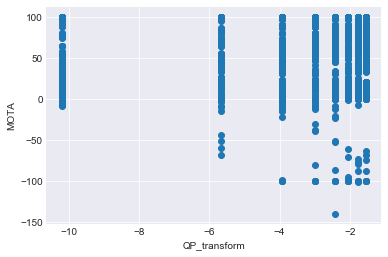

In [26]:
x = df_all_avg.query('QP > 0')['QP_transform']
y = df_all_avg.query('QP > 0')['MOTA']
plt.xlabel('QP_transform')
plt.ylabel('MOTA')
plt.scatter(x, y)

#### two-sample one-sided t-test ("all" object classes)

Perform two-sample one-sided t-test (see Douglas C. Montgomery, George C. Runger, Norma F. Hubele - Engineering Statistics, 5th Edition (2010, John Wiley) for the concept). Each sample is an average of 12 numerical values.

Assumption: both uncompressed compressed valuess distributions are normal distributions. Also, each variance is same.

$ H_0: \mu_{comp} = \mu_{uncomp}$


$ H_1: \mu_{comp} > \mu_{uncomp} $  (IDFN, FN, PT, ML)

$ H_1: \mu_{comp} < \mu_{uncomp} $ (else)


In [7]:
# from statsmodels.stats.weightstats import ttest_ind
import scipy

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']

qp_list = [18, 22, 26, 30, 34, 38, 42, 46]
header = list(df_all.iloc[:,5:])
df_stats = pd.DataFrame([])

## data wrangling
df_comp_all_msr16 = df_all.query('QP != 0 and MSR != 0 and MSR == 16')
df_uncomp_all_msr16 = df_all.query('QP == 0 and MSR == 0')

for metric in header:
    if metric == "GT":
        continue
    series = pd.Series()
    for qp in qp_list:
        avg_values = df_comp_all_msr16.query(f'QP == {qp}')[metric]
        uncomp_values = df_uncomp_all_msr16[metric]      
        
        # should I make it two-sided test for consistency or some metrics for one-sided left others for one-sided right?
        if metric == "IDFN" or metric == "FN" or metric == "ML" or metric == "PT":
            t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="greater")
#             t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="two-sided")
        else:
            t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="less")
#             t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="two-sided")

        series[f"p-value(QP={qp})"] =  float(p)
    
    df_stats[metric] = series
    
print(df_stats.to_latex(index=True, multirow=True))
display(df_stats)

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  IDTP &  IDFP &  IDFN &  IDF1 &  IDP &  IDR &  Recall &  Precision &   F1 &   MT &   PT &   ML &   TP &   FP &   FN &  IDs &   FM &  MOTA &  MOTP \\
\midrule
p-value(QP=18) &  0.49 &  0.53 &  0.50 &  0.53 & 0.52 & 0.52 &    0.49 &       0.45 & 0.49 & 0.45 & 0.48 & 0.48 & 0.50 & 0.53 & 0.50 & 0.53 & 0.50 &  0.48 &  0.51 \\
p-value(QP=22) &  0.51 &  0.50 &  0.51 &  0.52 & 0.51 & 0.52 &    0.46 &       0.43 & 0.46 & 0.48 & 0.52 & 0.47 & 0.50 & 0.54 & 0.50 & 0.51 & 0.52 &  0.45 &  0.52 \\
p-value(QP=26) &  0.48 &  0.45 &  0.49 &  0.53 & 0.58 & 0.49 &    0.41 &       0.56 & 0.45 & 0.41 & 0.46 & 0.47 & 0.47 & 0.47 & 0.48 & 0.48 & 0.47 &  0.45 &  0.57 \\
p-value(QP=30) &  0.48 &  0.52 &  0.49 &  0.46 & 0.50 & 0.43 &    0.40 &       0.57 & 0.44 & 0.37 & 0.46 & 0.44 & 0.49 & 0.51 & 0.49 & 0.47 & 0.47 &  0.44 &  0.54 \\
p-value(QP=34) &  0.42 &  0.47 &  0.45 &  0.36 & 0.48 & 0.30 &    0.24 &       0.60 & 0.32 & 0.28 & 0.52 & 0.34 & 0.42 & 0.47 

IDTP  IDFP  IDFN  IDF1  IDP  IDR  Recall  Precision   F1   MT   PT   ML   TP   FP   FN  IDs   FM  MOTA  MOTP
p-value(QP=18)  0.49  0.53  0.50  0.53 0.52 0.52    0.49       0.45 0.49 0.45 0.48 0.48 0.50 0.53 0.50 0.53 0.50  0.48  0.51
p-value(QP=22)  0.51  0.50  0.51  0.52 0.51 0.52    0.46       0.43 0.46 0.48 0.52 0.47 0.50 0.54 0.50 0.51 0.52  0.45  0.52
p-value(QP=26)  0.48  0.45  0.49  0.53 0.58 0.49    0.41       0.56 0.45 0.41 0.46 0.47 0.47 0.47 0.48 0.48 0.47  0.45  0.57
p-value(QP=30)  0.48  0.52  0.49  0.46 0.50 0.43    0.40       0.57 0.44 0.37 0.46 0.44 0.49 0.51 0.49 0.47 0.47  0.44  0.54
p-value(QP=34)  0.42  0.47  0.45  0.36 0.48 0.30    0.24       0.60 0.32 0.28 0.52 0.34 0.42 0.47 0.45 0.41 0.42  0.31  0.55
p-value(QP=38)  0.37  0.35  0.42  0.30 0.55 0.21    0.11       0.74 0.18 0.22 0.55 0.29 0.34 0.37 0.41 0.47 0.41  0.20  0.50
p-value(QP=42)  0.31  0.34  0.39  0.11 0.36 0.09    0.03       0.66 0.05 0.10 0.50 0.22 0.29 0.38 0.37 0.36 0.45  0.07  0.37
p-value(QP=46)  0.18  0.19  0.32  0.02 0.53 0.01    0.00       0.46 0.00 0.02 0.63 0.09 0.12 0.33 0.26 0.28 0.30  0.00  0.13

### two-sample one-sided t-test ("person" object classes)

In [8]:
from statsmodels.stats.weightstats import ttest_ind
import scipy

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']

# remove Cactus class since it does not have a "person" class
df = df.query('seq_name != "Cactus"')
df_0 = df[df['class_id'] == '0']

qp_list = [18, 22, 26, 30, 34, 38, 42, 46]
header = list(df_0.iloc[:,5:])
df_stats = pd.DataFrame([])

## data wrangling
df_comp_all_msr16 = df_0.query('QP != 0 and MSR != 0 and MSR == 16')
df_uncomp_all_msr16 = df_0.query('QP == 0 and MSR == 0')

for metric in header:
    if metric == "GT":
        continue
    series = pd.Series()
    for qp in qp_list:
        avg_values = df_comp_all_msr16.query(f'QP == {qp}')[metric]
        uncomp_values = df_uncomp_all_msr16[metric]
        
        # should I make it two-sided test for consistency or some metrics for one-sided left others for one-sided right?
        if metric == "IDFN" or metric == "FN" or metric == "ML" or metric == "PT":
            t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="greater")
#             t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="two-sided")
        else:
            t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="less")
#             t, p = scipy.stats.ttest_ind(avg_values, uncomp_values, alternative="two-sided")

        series[f"p-value(QP={qp})"] =  float(p)
    
    df_stats[metric] = series
    
print(df_stats.to_latex(index=True, multirow=True))
display(df_stats)

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  IDTP &  IDFP &  IDFN &  IDF1 &  IDP &  IDR &  Recall &  Precision &   F1 &   MT &   PT &   ML &   TP &   FP &   FN &  IDs &   FM &  MOTA &  MOTP \\
\midrule
p-value(QP=18) &  0.51 &  0.51 &  0.50 &  0.58 & 0.57 & 0.57 &    0.51 &       0.47 & 0.51 & 0.42 & 0.39 & 0.50 & 0.50 & 0.56 & 0.50 & 0.52 & 0.48 &  0.51 &  0.51 \\
p-value(QP=22) &  0.52 &  0.46 &  0.51 &  0.58 & 0.59 & 0.57 &    0.49 &       0.48 & 0.50 & 0.46 & 0.50 & 0.49 & 0.50 & 0.55 & 0.50 & 0.50 & 0.51 &  0.50 &  0.54 \\
p-value(QP=26) &  0.48 &  0.46 &  0.49 &  0.54 & 0.58 & 0.51 &    0.44 &       0.58 & 0.47 & 0.34 & 0.40 & 0.47 & 0.47 & 0.47 & 0.49 & 0.51 & 0.48 &  0.47 &  0.60 \\
p-value(QP=30) &  0.49 &  0.49 &  0.50 &  0.55 & 0.58 & 0.52 &    0.45 &       0.57 & 0.48 & 0.31 & 0.35 & 0.47 & 0.49 & 0.51 & 0.49 & 0.52 & 0.52 &  0.48 &  0.56 \\
p-value(QP=34) &  0.40 &  0.47 &  0.46 &  0.41 & 0.48 & 0.37 &    0.33 &       0.61 & 0.40 & 0.24 & 0.40 & 0.43 & 0.40 & 0.44 

IDTP  IDFP  IDFN  IDF1  IDP  IDR  Recall  Precision   F1   MT   PT   ML   TP   FP   FN  IDs   FM  MOTA  MOTP
p-value(QP=18)  0.51  0.51  0.50  0.58 0.57 0.57    0.51       0.47 0.51 0.42 0.39 0.50 0.50 0.56 0.50 0.52 0.48  0.51  0.51
p-value(QP=22)  0.52  0.46  0.51  0.58 0.59 0.57    0.49       0.48 0.50 0.46 0.50 0.49 0.50 0.55 0.50 0.50 0.51  0.50  0.54
p-value(QP=26)  0.48  0.46  0.49  0.54 0.58 0.51    0.44       0.58 0.47 0.34 0.40 0.47 0.47 0.47 0.49 0.51 0.48  0.47  0.60
p-value(QP=30)  0.49  0.49  0.50  0.55 0.58 0.52    0.45       0.57 0.48 0.31 0.35 0.47 0.49 0.51 0.49 0.52 0.52  0.48  0.56
p-value(QP=34)  0.40  0.47  0.46  0.41 0.48 0.37    0.33       0.61 0.40 0.24 0.40 0.43 0.40 0.44 0.46 0.49 0.46  0.38  0.57
p-value(QP=38)  0.32  0.40  0.43  0.32 0.48 0.26    0.21       0.65 0.27 0.14 0.31 0.41 0.31 0.34 0.42 0.57 0.47  0.25  0.57
p-value(QP=42)  0.28  0.42  0.41  0.10 0.29 0.10    0.12       0.58 0.14 0.07 0.21 0.38 0.28 0.37 0.40 0.53 0.56  0.13  0.42
p-value(QP=46)  0.12  0.19  0.34  0.02 0.42 0.01    0.01       0.36 0.01 0.01 0.16 0.25 0.09 0.35 0.30 0.51 0.53  0.01  0.21

In [258]:
# # ttest_ind(avg_values, uncomp_value, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)
# # statsmodel do not have one sample t-test
# metric = 'Rcll'
# qp = 18

# avg_values = df_comp_all_msr16.query(f'QP == {qp}')[metric]
# uncomp_values = df_uncomp_all_msr16[metric]

# print("12 values = ", list(avg_values))
# print("mean = ", float(np.mean(avg_values)))
# print("std = ", float(np.std(avg_values, ddof=1)))
# print("uncomp value = ", float(uncomp_value))
# # uncomp_values = df_uncomp_all_msr16
# df_all


### Two-way ANOVA

In [15]:
df_stats = pd.DataFrame([])


for metric in df_all_avg:
    if metric != 'qp' and metric != 'msr':
        result = smf.ols(formula=f"{metric} ~ C(qp) + C(msr)", data=df_all_avg).fit()
        table = sm.stats.anova_lm(result, typ=2) 
#         display(result.pvalues)
        df_stats[metric] = table['PR(>F)']

df_stats.drop(['Residual'])
display(df_stats)

# from scipy.stats import f_oneway
# scipy_res = f_oneway(df_all_avg[df_all_avg['msr']==16]['MOTA'],
#          df_all_avg[df_all_avg['msr']==32]['MOTA'],
#          df_all_avg[df_all_avg['msr']==64]['MOTA'])
# print(scipy_res)

IDF1  IDP  IDR  Rcll  Prcn   F1   MT   PT   ML   TP   FP   FN  IDs   FM  MOTA  MOTP
C(qp)     0.00 0.00 0.00  0.00  0.00 0.00 0.00 0.07 0.00 0.00 0.00 0.00 0.00 0.00  0.00  0.00
C(msr)    0.92 0.85 0.96  0.59  0.31 0.54 0.80 0.68 0.40 0.94 0.95 0.94 0.72 0.73  0.50  0.57
Residual   NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN

### ANCOVA

In [16]:
df_stats = pd.DataFrame([])

for metric in df_all_avg:
    if metric != 'qp' and metric != 'msr':
        result = smf.ols(formula=f"{metric} ~ qp + C(msr)", data=df_all_avg).fit()
        table = sm.stats.anova_lm(result, typ=2) 
#         display(result.pvalues)
        df_stats[metric] = table['PR(>F)']

df_stats.drop(['Residual'])
display(df_stats)

# from scipy.stats import f_oneway
# scipy_res = f_oneway(df_all_avg[df_all_avg['msr']==16]['MOTA'],
#          df_all_avg[df_all_avg['msr']==32]['MOTA'],
#          df_all_avg[df_all_avg['msr']==64]['MOTA'])
# print(scipy_res)

IDF1  IDP  IDR  Rcll  Prcn   F1   MT   PT   ML   TP   FP   FN  IDs   FM  MOTA  MOTP
C(msr)    1.00 0.90 1.00  1.00  0.93 1.00 1.00 0.75 0.99 1.00 0.99 1.00 0.82 0.95  1.00  0.94
qp        0.00 0.00 0.00  0.00  0.08 0.00 0.00 0.19 0.00 0.00 0.00 0.00 0.00 0.00  0.00  0.00
Residual   NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN

In [17]:
# # scikit-learn way
# X = df_all_avg[['qp', 'msr']]
# X['qp*msr'] = X['qp'] * X['msr']

# Y = df_all_avg[['MOTA', 'MOTP']]

# # follow the usual sklearn pattern: import, instantiate, fit
# model = LinearRegression()
# model.fit(X, Y)
# print(model.intercept_)
# print(model.coef_)



# from sklearn.cross_decomposition import CCA
# import seaborn as sns
# X = df_all_avg[['qp', 'msr']]
# Y = df_all_avg[['IDF1', 'IDP', 'IDR', 'Rcll', 'Prcn', 'F1', 'MT', 'PT',
#                'ML',  'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP', 'IDt', 'IDa', 'IDm']]
# X_mc = (X-X.mean())/(X.std())
# Y_mc = (Y-Y.mean())/(Y.std())

# ca = CCA()
# ca.fit(X_mc, Y_mc)
# X_c, Y_c = ca.transform(X_mc, Y_mc)

# dfmap = pd.DataFrame({"qp":X_c[:, 0],
#                       "msr":X_c[:, 1],
#                       "IDF1":Y_c[:,0],
#                       "IDP": Y_c[:,1]})

# dfmap_corr = dfmap.corr(method='pearson')
# plt.figure(figsize=(10,8))
# dfmap_corr_plt = dfmap_corr.where(np.tril(np.ones(dfmap_corr.shape)).astype(np.bool))
# sns.heatmap(dfmap_corr_plt, cmap="coolwarm",annot=True, fmt='.1g')
# plt.tight_layout()

# data = df_all_avg[['qp', 'msr','IDF1', 'IDP', 'IDR', 'Rcll', 'Prcn', 'F1', 'MT', 'PT',
#                'ML',  'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP', 'IDt', 'IDa', 'IDm']]

# corrMatrix = data.corr()
# # sns.heatmap(corrMatrix, annot=False)
# plt.figure(figsize=(30,24))
# sns.heatmap(corrMatrix, cmap="coolwarm",annot=True, fmt='.1g')
# plt.show()


IDTP  IDFP  IDFN  IDF1   IDP   IDR  Recall  Precision    F1    GT    MT    PT    ML    TP    FP    FN   IDs    FM  MOTA  MOTP
IDTP       1.00  0.37  0.32  0.25  0.34  0.25   -0.09      -0.64 -0.18  0.50  0.87 -0.35  0.31  0.94  0.83  0.34 -0.20 -0.21 -0.20 -0.56
IDFP       0.37  1.00  0.48 -0.55 -0.63 -0.49   -0.21      -0.33 -0.21  0.49  0.47  0.28  0.25  0.65  0.37  0.37  0.73  0.73 -0.25 -0.65
IDFN       0.32  0.48  1.00 -0.57 -0.08 -0.60   -0.76      -0.63 -0.80  0.93  0.25 -0.19  0.95  0.37  0.54  0.99  0.02  0.04 -0.77 -0.58
IDF1       0.25 -0.55 -0.57  1.00  0.73  0.98    0.67       0.15  0.62 -0.47  0.25 -0.39 -0.46  0.04 -0.01 -0.50 -0.55 -0.58  0.62  0.54
IDP        0.34 -0.63 -0.08  0.73  1.00  0.63    0.00      -0.26 -0.05  0.05  0.25 -0.59  0.15  0.04  0.29  0.04 -0.85 -0.86 -0.03  0.28
IDR        0.25 -0.49 -0.60  0.98  0.63  1.00    0.76       0.20  0.70 -0.52  0.26 -0.37 -0.52  0.08 -0.05 -0.54 -0.47 -0.50  0.71  0.53
Recall    -0.09 -0.21 -0.76  0.67  0.00  0.76    1.00       0.59  0.99 -0.78  0.06 -0.00 -0.83 -0.08 -0.43 -0.78  0.06  0.02  0.99  0.56
Precision -0.64 -0.33 -0.63  0.15 -0.26  0.20    0.59       1.00  0.66 -0.70 -0.42  0.40 -0.71 -0.55 -0.93 -0.67  0.30  0.28  0.68  0.51
F1        -0.18 -0.21 -0.80  0.62 -0.05  0.70    0.99       0.66  1.00 -0.81 -0.01  0.11 -0.88 -0.15 -0.50 -0.82  0.13  0.09  0.99  0.58
GT         0.50  0.49  0.93 -0.47  0.05 -0.52   -0.78      -0.70 -0.81  1.00  0.43 -0.12  0.93  0.52  0.66  0.93  0.00  0.01 -0.80 -0.66
MT         0.87  0.47  0.25  0.25  0.25  0.26    0.06      -0.42 -0.01  0.43  1.00 -0.36  0.19  0.89  0.62  0.24 -0.01 -0.04 -0.02 -0.48
PT        -0.35  0.28 -0.19 -0.39 -0.59 -0.37   -0.00       0.40  0.11 -0.12 -0.36  1.00 -0.32 -0.15 -0.41 -0.27  0.70  0.73  0.03 -0.08
ML         0.31  0.25  0.95 -0.46  0.15 -0.52   -0.83      -0.71 -0.88  0.93  0.19 -0.32  1.00  0.27  0.59  0.97 -0.22 -0.21 -0.84 -0.49
TP         0.94  0.65  0.37  0.04  0.04  0.08   -0.08      -0.55 -0.15  0.52  0.89 -0.15  0.27  1.00  0.73  0.34  0.13  0.12 -0.17 -0.67
FP         0.83  0.37  0.54 -0.01  0.29 -0.05   -0.43      -0.93 -0.50  0.66  0.62 -0.41  0.59  0.73  1.00  0.58 -0.30 -0.30 -0.53 -0.58
FN         0.34  0.37  0.99 -0.50  0.04 -0.54   -0.78      -0.67 -0.82  0.93  0.24 -0.27  0.97  0.34  0.58  1.00 -0.11 -0.09 -0.79 -0.55
IDs       -0.20  0.73  0.02 -0.55 -0.85 -0.47    0.06       0.30  0.13  0.00 -0.01  0.70 -0.22  0.13 -0.30 -0.11  1.00  0.99  0.08 -0.26
FM        -0.21  0.73  0.04 -0.58 -0.86 -0.50    0.02       0.28  0.09  0.01 -0.04  0.73 -0.21  0.12 -0.30 -0.09  0.99  1.00  0.04 -0.29
MOTA      -0.20 -0.25 -0.77  0.62 -0.03  0.71    0.99       0.68  0.99 -0.80 -0.02  0.03 -0.84 -0.17 -0.53 -0.79  0.08  0.04  1.00  0.60
MOTP      -0.56 -0.65 -0.58  0.54  0.28  0.53    0.56       0.51  0.58 -0.66 -0.48 -0.08 -0.49 -0.67 -0.58 -0.55 -0.26 -0.29  0.60  1.00

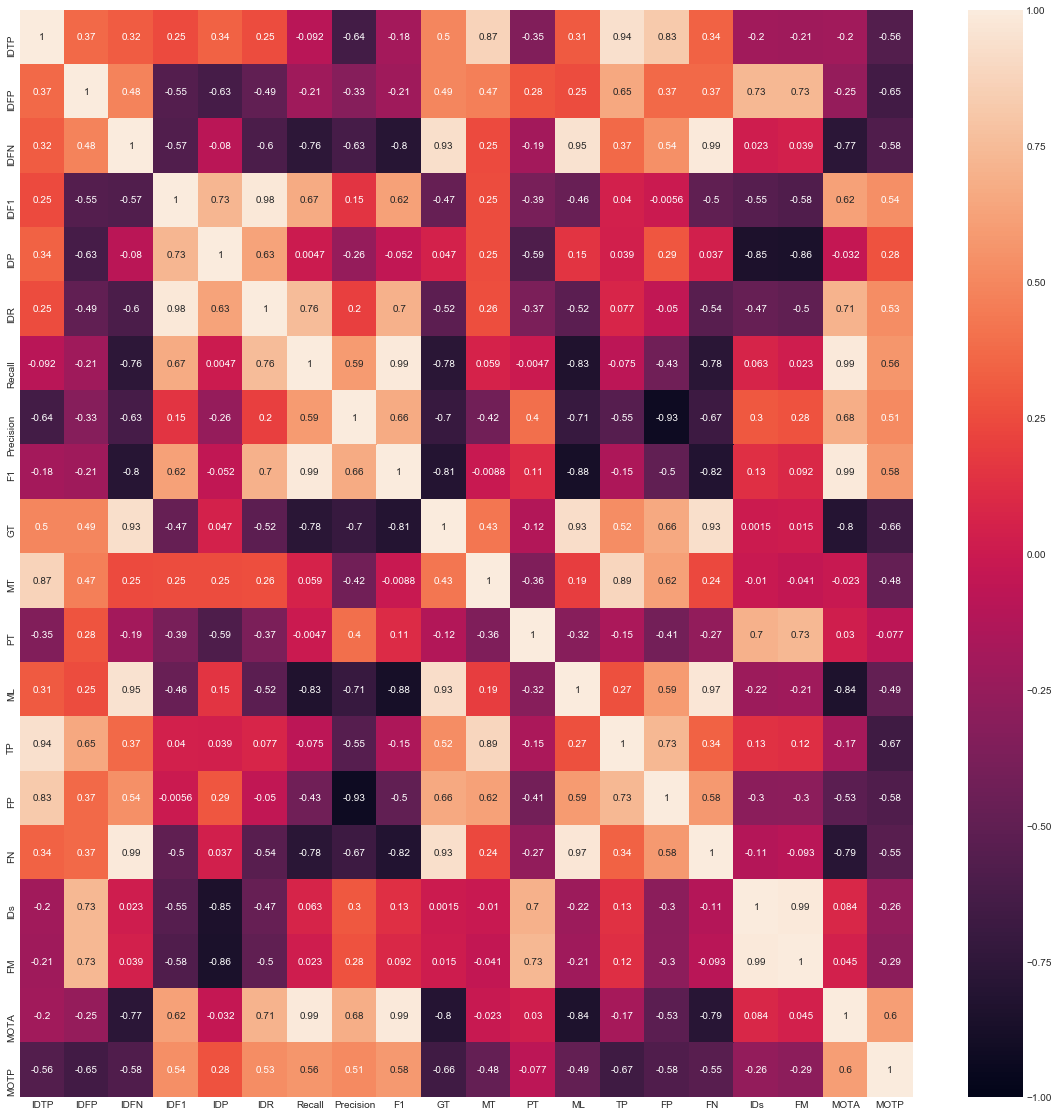

In [22]:
import seaborn as sns
from scipy.stats import kendalltau, pearsonr, spearmanr
#https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas

def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

seq_name_list = ['BasketballDrive', 'Cactus', 'Kimono', 'ParkScene',
        'BasketballDrill', 'RaceHorsesC',
        'BasketballPass', 'BlowingBubbles', 'RaceHorsesD',
        'FourPeople', 'Johnny', 'KristenAndSara']

# corr_df_sum = 0
# for seq_name in seq_name_list:
#     df_all_msr16 = df_all.query(f'MSR == 16 and seq_name == "{seq_name}"')
#     corr_df = df_all_msr16.iloc[:,5:].corr()
#     corr_df_sum += corr_df
# #     display(corr_df)
    
# corr_df_sum /= 12
# corr_df = corr_df_sum
# display(corr_df)

df_all_msr16 = df.query('MSR == 16 and class_id=="0"')
corr_df = df_all_msr16.iloc[:,5:].corr() # correlation coefficient
# or corr_df = df_all_msr16.iloc[:,5:].corr(method=pearsonr_pval) # p-values
# corr_df = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool)) # triagnle shape
display(corr_df)


plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, square=False)
ax.set_ylim(20, 0)
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/correlation.pdf", bbox_inches="tight")

# Including Standard deviation for df_summary
Very bad implementation of looping through df_summary in both row and col

In [155]:
visual_metric = "MOTA"

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])

header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']
df = df[header] # re-arrange
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
# display(df_all)
seq_list = list(df['seq_name'].unique())
num_seq = len(seq_list)
temp_data = df_all[df_all['seq_name'] == "BasketballDrive"]


#initialize df_summary
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'MOTA', 'MOTP']

#header_std = [f"{col}_std" for col in header ]#if col !='QP' and col != 'MSR']
df_summary = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)
df_summary_mean = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)
df_summary_std = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)
for col in df_summary:
    df_summary[col] = df_summary[col].apply(lambda x: [] if col != 'QP' and col != 'MSR' else x)

for seq_name in seq_list:
    if seq_name == "PartyScene": # skip this seq at the moment since experiment fails
        continue
    df_seq_all = df_all[df_all['seq_name'] == seq_name]
    df_seq_all.pop('class_cat')
    df_seq_all.pop('seq_name')
    df_seq_all.pop('class_id')
    
#     df_seq_all['TP'] = 0

    df_seq_all = df_seq_all.reset_index(drop=True)
    for col in df_seq_all:
        for i in range(len(df_seq_all[col])):
            if col == 'QP' or col == 'MSR':
                # assign series directly
                df_summary[col][i] = df_seq_all[col][i]
            else:
                df_summary[col][i] += [df_seq_all[col][i]]

for col in df_summary:
    if col == 'QP' or col == 'MSR':
        df_summary_mean[col] = df_summary[col]
        df_summary_std[col] = df_summary[col]
    else:
        df_summary_mean[col] = df_summary[col].apply(lambda el: np.mean(el))
        df_summary_std[col] = df_summary[col].apply(lambda el: np.std(el, ddof=1))

df_seq_cl = df_summary_mean
df_seq_cl_std = df_summary_std
df_seq_cl_uncomp = df_seq_cl[df_seq_cl['MSR'] == 0].reset_index(drop=True) # reset index so that you can access the first element
df_seq_cl_msr8 = df_seq_cl[df_seq_cl['MSR'] == 8]
df_seq_cl_msr16 = df_seq_cl[df_seq_cl['MSR'] == 16]
df_seq_cl_msr32 = df_seq_cl[df_seq_cl['MSR'] == 32]
df_seq_cl_msr64 = df_seq_cl[df_seq_cl['MSR'] == 64]

df_seq_cl_uncomp_std = df_seq_cl_std[df_seq_cl_std['MSR'] == 0].reset_index(drop=True) # reset index so that you can access the first element
df_seq_cl_msr8_std = df_seq_cl_std[df_seq_cl_std['MSR'] == 8]
df_seq_cl_msr16_std = df_seq_cl_std[df_seq_cl_std['MSR'] == 16]
df_seq_cl_msr32_std = df_seq_cl_std[df_seq_cl_std['MSR'] == 32]
df_seq_cl_msr64_std = df_seq_cl_std[df_seq_cl_std['MSR'] == 64]

with pd.option_context('precision', 2):
    print("mean results")
    df_seq_cl_uncomp['QP'] = 'Uncompressed'
    df_seq_cl_uncomp['MSR'] = 'Uncompressed'
    display(df_seq_cl_uncomp)
    display(df_seq_cl_msr8)
    display(df_seq_cl_msr16)
    display(df_seq_cl_msr32)
    display(df_seq_cl_msr64)
    print("std results")
    df_seq_cl_uncomp_std['QP'] = 'Uncompressed'
    df_seq_cl_uncomp_std['MSR'] = 'Uncompressed'
    display(df_seq_cl_uncomp_std)
    display(df_seq_cl_msr8_std)
    display(df_seq_cl_msr16_std)
    display(df_seq_cl_msr32_std)
    display(df_seq_cl_msr64_std)
    
print(df_seq_cl_uncomp_std.to_latex(index=False, multirow=True))
print(df_seq_cl_msr8_std.to_latex(index=False, multirow=True))
print(df_seq_cl_msr16_std.to_latex(index=False, multirow=True))
print(df_seq_cl_msr32_std.to_latex(index=False, multirow=True))
print(df_seq_cl_msr64_std.to_latex(index=False, multirow=True))
    
fig = go.Figure()
x_base = df_seq_cl_msr8['QP']
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr8[visual_metric],
                    error_y=dict(
                        type='data', # value of error bar given in data coordinates
                        array=df_seq_cl_msr16_std[visual_metric],
                        visible=True),
                    mode='lines+markers',
                    name='MSR=8'))
fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr16[visual_metric],
                    error_y=dict(
                        type='data', # value of error bar given in data coordinates
                        array=df_seq_cl_msr16_std[visual_metric],
                        visible=True),
                    mode='lines+markers',
                    name='MSR=16'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr32[visual_metric],
                    error_y=dict(
                        type='data', # value of error bar given in data coordinates
                        array=df_seq_cl_msr32_std[visual_metric],
                        visible=True),
                    mode='lines+markers',
                    name='MSR=32'))

fig.add_trace(go.Scatter(x=x_base, y=df_seq_cl_msr64[visual_metric],
                    error_y=dict(
                        type='data', # value of error bar given in data coordinates
                        array=df_seq_cl_msr64_std[visual_metric],
                        visible=True),
                    mode='lines+markers',
                    name='MSR=64'))
x_name = "QP"
y_name = visual_metric
z_name = "MSR"
fig.update_layout( font=dict(
                color="black",
                size=14),
                   xaxis_title=x_name,
                   yaxis_title=y_name)

fig.show()
fig.write_image("C:/OneDrive/SFU/ENSC498, 499/images/averaged_all_MOTA_std.pdf",width=1000, height=576)

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



mean results


QP           MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
0  Uncompressed  Uncompressed 1762.58 932.83 2522.67 49.88 61.13 43.48 62.17 89.25 72.08 12.25 4.67 3.25 4.33 2249.75 441.67 2035.50 24.08 35.17 54.49  0.18

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
1   18    8 1770.08 947.50 2515.17 50.60 61.55 44.26 62.18 88.58 71.92 12.25 4.50 3.17 4.58 2246.75 466.83 2038.50 24.17 36.00 53.97  0.18
5   22    8 1780.83 931.92 2504.42 50.46 61.66 43.96 61.62 88.85 71.65 12.25 4.58 3.17 4.50 2250.00 458.75 2035.25 24.92 35.58 53.70  0.18
9   26    8 1751.67 874.17 2533.58 50.41 62.63 43.28 60.49 89.73 71.22 12.25 4.33 3.17 4.75 2192.92 428.92 2092.33 24.33 35.50 53.24  0.18
13  30    8 1731.50 960.08 2553.75 49.88 62.12 42.65 60.21 89.82 71.07 12.25 4.33 3.08 4.83 2234.42 453.17 2050.83 23.67 35.00 53.13  0.18
17  34    8 1653.92 855.08 2631.33 48.14 62.23 39.93 57.12 90.61 69.26 12.25 4.08 3.00 5.17 2092.58 412.42 2192.67 21.75 32.25 50.64  0.18
21  38    8 1488.50 781.08 2796.75 44.56 61.38 35.62 52.70 91.52 65.97 12.25 3.42 3.17 5.67 1912.42 353.17 2372.83 21.92 30.67 47.15  0.18
25  42    8 1399.25 733.83 2886.00 40.92 60.67 32.08 46.86 91.35 60.24 12.25 3.08 3.25 5.92 1805.67 323.42 2479.58 20.83 33.50 41.48  0.19
29  46    8 1046.50 673.33 3238.75 30.48 57.12 22.40 33.09 87.46 45.48 12.25 1.75 3.08 7.42 1358.33 357.50 2926.92 18.00 28.25 27.64  0.20

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
2   18   16 1749.25 964.25 2536.00 50.48 61.51 44.07 62.04 88.73 71.88 12.25 4.50 3.33 4.42 2248.00 461.50 2037.25 25.08 35.25 54.03  0.18
6   22   16 1790.08 932.17 2495.17 50.40 61.45 43.96 61.39 88.42 71.38 12.25 4.58 3.17 4.50 2242.17 476.08 2043.08 24.33 35.75 53.36  0.18
10  26   16 1728.75 886.25 2556.50 50.48 62.82 43.28 60.43 89.89 71.21 12.25 4.33 3.42 4.50 2190.50 420.50 2094.75 23.58 34.08 53.36  0.18
14  30   16 1728.33 954.08 2556.92 48.91 61.02 41.83 60.04 90.00 71.10 12.25 4.17 3.42 4.67 2225.42 453.00 2059.83 23.17 34.25 53.21  0.18
18  34   16 1604.67 906.00 2680.58 46.94 60.73 38.90 56.89 90.40 69.10 12.25 3.83 3.17 5.25 2087.08 419.58 2198.17 21.67 32.08 50.49  0.18
22  38   16 1496.58 791.58 2788.67 45.47 62.23 36.46 53.13 91.95 66.47 12.25 3.58 3.08 5.58 1934.58 349.58 2350.67 23.17 31.83 47.81  0.18
26  42   16 1379.33 786.17 2905.92 39.76 58.32 31.38 47.28 90.98 60.56 12.25 2.92 3.25 6.08 1809.33 352.17 2475.92 20.33 33.58 41.72  0.19
30  46   16 1078.17 613.00 3207.08 32.43 61.75 23.68 33.48 88.70 45.99 12.25 1.92 2.83 7.50 1368.58 318.58 2916.67 18.42 28.58 27.67  0.20

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
3   18   32 1768.58 939.58 2516.67 50.68 61.70 44.31 61.98 88.62 71.78 12.25 4.58 3.25 4.42 2245.33 458.83 2039.92 25.00 35.58 53.80  0.18
7   22   32 1791.42 920.08 2493.83 50.38 61.48 43.92 61.49 88.46 71.42 12.25 4.58 3.25 4.42 2254.00 453.50 2031.25 25.00 36.42 53.15  0.18
11  26   32 1724.42 939.08 2560.83 49.68 61.44 42.83 60.80 89.44 71.32 12.25 4.42 3.08 4.75 2204.33 455.17 2080.92 24.25 35.75 53.41  0.18
15  30   32 1697.08 950.92 2588.17 49.14 61.34 41.91 59.79 89.85 70.91 12.25 4.17 3.42 4.67 2196.08 447.92 2089.17 24.08 36.58 52.83  0.18
19  34   32 1628.42 865.50 2656.83 48.13 61.98 39.98 57.10 90.70 69.32 12.25 4.00 3.00 5.25 2096.75 393.17 2188.50 21.42 31.58 50.82  0.18
23  38   32 1512.50 778.75 2772.75 45.10 61.90 36.13 53.20 91.29 66.31 12.25 3.58 3.08 5.58 1934.67 352.58 2350.58 20.75 31.08 47.57  0.18
27  42   32 1367.25 779.58 2918.00 39.92 58.70 31.38 47.28 90.61 60.48 12.25 3.00 3.42 5.83 1808.25 334.58 2477.00 19.67 32.25 41.48  0.19
31  46   32 1018.67 693.75 3266.58 30.48 57.32 22.52 33.53 88.54 45.93 12.25 1.75 3.08 7.42 1363.75 344.67 2921.50 19.25 28.25 27.97  0.19

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1    GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
4   18   64 1756.00 964.33 2529.25 50.10 61.04 43.73 62.17 88.82 72.02 12.25 4.67 3.00 4.58 2252.83 463.50 2032.42 24.75 36.75 54.24  0.18
8   22   64 1768.75 944.75 2516.50 50.68 61.77 44.22 61.56 88.53 71.48 12.25 4.42 3.33 4.50 2244.83 464.67 2040.42 24.75 36.75 53.33  0.18
12  26   64 1722.25 906.50 2563.00 49.46 61.60 42.30 60.18 89.24 70.90 12.25 4.33 3.25 4.67 2184.42 440.33 2100.83 24.33 34.50 52.62  0.18
16  30   64 1731.25 949.00 2554.00 49.44 61.59 42.27 59.80 89.16 70.64 12.25 4.33 3.08 4.83 2214.75 461.50 2070.50 23.83 34.50 52.47  0.18
20  34   64 1615.58 880.42 2669.67 46.90 60.65 38.91 57.32 91.40 69.69 12.25 3.83 3.25 5.17 2102.25 389.75 2183.00 20.92 32.17 51.51  0.18
24  38   64 1508.92 765.42 2776.33 46.25 63.23 37.09 52.56 90.69 65.69 12.25 3.50 3.08 5.67 1917.75 352.58 2367.50 20.33 31.83 46.48  0.18
28  42   64 1404.50 744.42 2880.75 42.43 62.55 33.18 47.31 90.25 60.65 12.25 3.00 3.33 5.92 1805.17 339.75 2480.08 18.83 32.75 41.57  0.19
32  46   64  995.00 729.42 3290.25 29.98 56.74 22.02 33.18 87.92 45.43 12.25 1.75 3.08 7.42 1364.33 356.08 2920.92 19.25 29.17 27.29  0.19

std results


QP           MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1   GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
0  Uncompressed  Uncompressed 2064.78 920.95 3363.60 21.39 19.91 23.64 20.12 10.80 16.29 7.70 3.52 3.72 5.42 2050.74 731.69 3253.93 28.13 36.08 21.79  0.05

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1   GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
1   18    8 2060.04 979.45 3377.44 22.75 21.09 24.90 19.98 11.66 16.32 7.70 3.61 3.43 5.30 2058.07 778.56 3241.03 27.89 36.76 22.21  0.05
5   22    8 2090.58 933.34 3335.78 22.71 20.92 24.90 19.95 11.46 16.29 7.70 3.55 3.61 5.32 2072.84 756.57 3219.86 27.76 35.89 22.36  0.05
9   26    8 2030.44 843.94 3236.65 21.82 20.84 23.07 18.51 11.00 15.54 7.70 3.47 3.46 5.51 1994.64 714.86 3185.43 27.07 35.28 20.68  0.05
13  30    8 1980.42 973.34 3268.86 20.86 20.46 22.09 18.64 10.38 15.17 7.70 3.70 3.34 5.18 2085.29 770.80 3132.23 26.29 33.79 20.91  0.05
17  34    8 1879.30 868.16 3230.65 19.17 20.30 18.72 15.42 10.75 13.68 7.70 3.50 3.49 5.27 1884.81 702.41 3113.31 24.99 33.42 17.89  0.05
21  38    8 1702.59 757.26 3326.29 17.56 20.63 16.08 14.58  9.68 13.15 7.70 3.12 3.38 5.28 1707.19 594.40 3227.73 25.31 33.33 15.75  0.05
25  42    8 1706.42 726.48 3431.96 17.76 18.58 17.50 17.53  9.54 15.68 7.70 3.23 3.19 5.26 1798.04 547.93 3299.26 22.50 29.19 17.55  0.05
29  46    8 1392.69 859.76 3567.74 16.97 17.51 15.36 18.60 12.29 19.96 7.70 2.09 2.47 5.53 1530.73 732.53 3438.87 16.26 24.77 18.38  0.04

QP  MSR    IDTP    IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1   GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
2   18   16 2011.62 1027.53 3447.42 22.45 20.88 24.53 20.15 11.59 16.48 7.70 3.61 3.65 5.28 2055.22 768.69 3246.40 28.47 36.29 22.45  0.05
6   22   16 2113.02  934.99 3310.19 23.44 21.89 25.45 20.20 11.64 16.63 7.70 3.55 3.61 5.42 2063.34 786.66 3233.91 28.68 36.85 22.93  0.05
10  26   16 1977.59  886.72 3304.55 21.98 21.12 23.09 18.54 10.99 15.57 7.70 3.52 3.78 5.21 1993.54 694.27 3178.99 27.47 34.43 20.66  0.05
14  30   16 1991.49  997.00 3336.38 23.54 23.96 24.26 18.50 10.96 15.35 7.70 3.61 3.92 5.28 2067.08 745.75 3142.65 26.21 33.11 21.30  0.05
18  34   16 1822.60  933.65 3313.62 19.61 20.81 19.14 15.28 10.60 13.68 7.70 3.35 3.43 5.24 1883.27 693.22 3115.29 26.03 34.02 17.93  0.05
22  38   16 1674.77  814.20 3399.62 18.00 20.17 16.87 14.47  9.65 13.09 7.70 3.09 3.29 5.32 1726.97 600.13 3232.38 25.45 32.75 15.83  0.05
26  42   16 1699.11  782.77 3465.90 17.88 18.58 17.87 17.71 10.17 15.78 7.70 2.91 2.86 5.38 1781.06 629.23 3354.80 22.51 29.91 17.94  0.05
30  46   16 1385.56  796.19 3581.80 16.58 19.46 15.00 18.15 14.03 19.15 7.70 2.23 2.33 5.76 1514.79 636.69 3450.12 17.41 24.10 18.67  0.04

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1   GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
3   18   32 2043.60 978.25 3401.33 23.06 21.33 25.21 20.14 11.93 16.49 7.70 3.55 3.72 5.37 2052.97 772.83 3251.43 28.59 35.81 22.60  0.05
7   22   32 2120.42 901.69 3298.39 23.13 21.77 25.10 19.87 11.67 16.22 7.70 3.55 3.70 5.21 2077.58 742.03 3204.20 28.72 35.76 22.54  0.05
11  26   32 1996.29 974.00 3345.79 21.15 19.81 22.76 19.07 11.20 15.89 7.70 3.45 3.48 5.41 2017.05 773.88 3200.13 27.29 35.99 21.35  0.05
15  30   32 1928.22 979.63 3326.39 22.31 22.40 22.85 17.73 10.88 15.02 7.70 3.41 3.42 5.26 2004.73 736.84 3133.16 26.69 34.16 20.50  0.05
19  34   32 1825.27 900.55 3318.31 21.58 22.86 20.77 15.35 10.10 13.65 7.70 3.52 3.49 5.24 1890.05 641.81 3105.59 25.81 33.10 17.81  0.05
23  38   32 1685.45 781.39 3360.86 18.07 20.98 16.68 14.66  9.34 13.01 7.70 3.09 3.29 5.32 1727.57 581.72 3225.25 23.83 32.00 15.73  0.05
27  42   32 1648.36 734.24 3389.41 15.87 16.67 15.80 17.39 10.31 15.50 7.70 3.05 3.15 5.41 1790.08 590.90 3320.16 21.98 30.56 17.76  0.05
31  46   32 1349.58 853.75 3656.11 16.71 16.56 15.46 18.52 12.12 19.61 7.70 2.30 2.91 5.79 1524.22 654.05 3456.88 16.90 23.08 17.82  0.04

QP  MSR    IDTP   IDFP    IDFN  IDF1   IDP   IDR  Rcll  Prcn    F1   GT   MT   PT   ML      TP     FP      FN   IDs    FM  MOTA  MOTP
4   18   64 2046.04 982.64 3395.07 21.92 20.27 24.08 20.05 11.46 16.41 7.70 3.52 3.46 5.48 2059.74 767.82 3239.35 28.20 36.91 22.29  0.05
8   22   64 2065.76 985.02 3377.98 23.29 21.89 25.24 19.86 11.62 16.18 7.70 3.63 3.65 5.35 2072.95 771.13 3214.79 28.75 37.09 22.30  0.05
12  26   64 1973.12 860.48 3209.07 20.43 20.00 21.36 18.20 11.00 15.46 7.70 3.50 3.62 5.14 1962.76 739.29 3167.65 27.64 35.15 20.74  0.05
16  30   64 2017.15 914.00 3239.18 21.74 21.74 22.71 18.74 11.22 15.66 7.70 3.68 3.42 5.32 2060.76 748.33 3164.25 27.02 33.51 21.70  0.05
20  34   64 1819.18 913.01 3317.98 21.57 22.88 20.80 15.38 10.22 13.66 7.70 3.35 3.55 5.27 1884.95 663.61 3108.10 23.93 33.79 17.90  0.05
24  38   64 1669.71 764.32 3358.91 17.47 19.86 16.16 13.86  9.62 12.50 7.70 2.91 3.34 5.28 1698.78 583.67 3238.10 23.42 30.96 14.96  0.05
28  42   64 1621.58 730.11 3428.76 16.23 18.02 16.08 16.95  9.65 15.01 7.70 2.95 3.06 5.37 1764.65 572.65 3350.99 19.69 29.51 17.48  0.05
32  46   64 1288.47 945.93 3654.56 16.93 20.13 15.05 18.78 13.81 19.93 7.70 2.49 2.75 5.74 1544.48 696.43 3445.22 18.40 25.99 18.86  0.04

\begin{tabular}{llrrrrrrrrrrrrrrrrrrrr}
\toprule
          QP &          MSR &    IDTP &   IDFP &    IDFN &  IDF1 &   IDP &   IDR &  Rcll &  Prcn &    F1 &   GT &   MT &   PT &   ML &      TP &     FP &      FN &   IDs &    FM &  MOTA &  MOTP \\
\midrule
Uncompressed & Uncompressed & 2064.78 & 920.95 & 3363.60 & 21.39 & 19.91 & 23.64 & 20.12 & 10.80 & 16.29 & 7.70 & 3.52 & 3.72 & 5.42 & 2050.74 & 731.69 & 3253.93 & 28.13 & 36.08 & 21.79 &  0.05 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrrrrrrrrrrrrrrrrr}
\toprule
 QP &  MSR &    IDTP &   IDFP &    IDFN &  IDF1 &   IDP &   IDR &  Rcll &  Prcn &    F1 &   GT &   MT &   PT &   ML &      TP &     FP &      FN &   IDs &    FM &  MOTA &  MOTP \\
\midrule
 18 &    8 & 2060.04 & 979.45 & 3377.44 & 22.75 & 21.09 & 24.90 & 19.98 & 11.66 & 16.32 & 7.70 & 3.61 & 3.43 & 5.30 & 2058.07 & 778.56 & 3241.03 & 27.89 & 36.76 & 22.21 &  0.05 \\
 22 &    8 & 2090.58 & 933.34 & 3335.78 & 22.71 & 20.92 & 24.90 & 19.95 & 11.46 & 16.29 & 7.70 & 3.55 &